In [61]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt 
import time

HMC
---

In [62]:
# Big data

# generate more tomatoe-like data
N = 30
d1 = np.random.normal(11,0.5,int(N/3))
d2 = np.random.normal(13,0.6,int((N-int(N/3))/2))
d3 = np.random.normal(16,0.4,N-2*int((N-int(N/3))/2))

Y = np.random.choice(np.concatenate([d1,d2,d3]), N, replace=True)

In [185]:
# generate more tomatoe-like data
N = 1000
d1 = np.random.normal(11.2115,0.5486,int(N/3))
d2 = np.random.normal(13.5618,0.62927,int((N-int(N/3))/2))
d3 = np.random.normal(16.115,0.5714,N-2*int((N-int(N/3))/2))

BigY = np.random.choice(np.concatenate([d1,d2,d3]), N, replace=True)

In [64]:
def force(q,y):
    m1,m2,m3 = q  
    
    n = len(y)
    p_prior = np.exp(-(13.5 - m1)**2/32)*np.exp(-(13.5 - m2)**2/32)*np.exp(-(13.5 - m3)**2/32)
    
    m1_vec = m1*np.ones(n)
    m2_vec = m2*np.ones(n)
    m3_vec = m3*np.ones(n)
    p_hat = np.exp(-(y-m1_vec)**2/2) + np.exp(-(y-m2_vec)**2/2) + np.exp(-(y-m3_vec)**2/2)
    
    # Take the negative of each gradient
    grad_m1 = -(-(1/16)*(13.5 - m1) + sum(-(y - m1_vec)*np.exp(-(y - m1_vec)**2/2)/p_hat))
    grad_m2 = -(-(1/16)*(13.5 - m2) + sum(-(y - m2_vec)*np.exp(-(y - m2_vec)**2/2)/p_hat))
    grad_m3 = -(-(1/16)*(13.5 - m3) + sum(-(y - m3_vec)*np.exp(-(y - m3_vec)**2/2)/p_hat))
    
    return grad_m1,grad_m2,grad_m3

In [65]:
def run_simulation_with_data( q0,p0, Nsteps, h, gamma, step_function, force_function, Y):
    
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 

    for n in range(Nsteps):
        q,p = step_function(q, h, Y)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t] 

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, p_traj, t_traj

def U(q,y):
    m1,m2,m3 = q 
    
    n = len(y)
    p_prior = np.exp(-(13.5-m1)**2/32)*np.exp(-(13.5 - m2)**2/32)*np.exp(-(13.5 - m3)**2/32)
    log_prior = np.log(p_prior)
    m1_vec = m1*np.ones(n)
    m2_vec = m2*np.ones(n)
    m3_vec = m3*np.ones(n)
    p_hat = np.exp(-(y-m1_vec)**2/2) + np.exp(-(y-m2_vec)**2/2) + np.exp(-(y-m3_vec)**2/2)
    log_p_hat = np.log(p_hat)
    V = -log_prior - sum(log_p_hat)
    
    return V

In [66]:
def HMC_with_data(q0,h,y):
    q = q0
    p = np.random.randn(3)
    current_p = p
    
    p = p + h*np.asarray(force(q,y))/2
    q = q + h*p
    p = p + h*np.asarray(force(q,y))/2
    p = -p
    
    current_U = U(q0,y)
    current_K = sum(current_p**2)/2
    proposed_U = U(q, y)
    proposed_K = sum(p**2)/2
    
    accept = -1
    if np.random.uniform(0,1) < np.exp(current_U - proposed_U + current_K - proposed_K):
        accept = 1
        return q, accept      # accept
    else:
        accept = 0
        return q0, accept     # reject
    
 

In [67]:
q0 = np.random.randn(3) + 13   # initialise q0 to be close to the mean (of tomato mass)
p0 = np.random.randn(3)

In [172]:
Nsteps = 100000
h = 0.1

tic = time.clock()

# Run one long trajectory of Nsteps, using the ABO scheme
q_traj, p_traj, t_traj = run_simulation_with_data(q0, p0, Nsteps , h, gamma, HMC_with_data, force, Y)
toc = time.clock()
print(toc - tic)


33.681857000000036


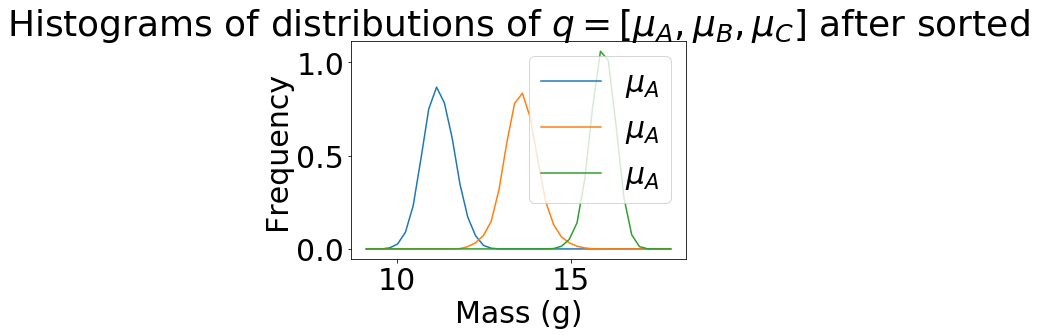

In [173]:

n = q_traj.shape[0]  # get number of time steps
q_traj_sorted = q_traj.copy()

for k in range(n):
    q_traj_sorted[k] = np.sort(q_traj[k])
    
hist1,bins1 = np.histogram(q_traj_sorted[:,0], bins=40,range=[9,18], density=True)
midx1 = (bins1[0:-1]+bins1[1:])/2
hist2,bins2 = np.histogram(q_traj_sorted[:,1], bins=40,range=[9,18], density=True)
midx2 = (bins2[0:-1]+bins2[1:])/2
hist3,bins3 = np.histogram(q_traj_sorted[:,2], bins=40,range=[9,18], density=True)
midx3 = (bins3[0:-1]+bins3[1:])/2
plt.plot(midx1,hist1,label='$\mu_A$')
plt.plot(midx2,hist2,label='$\mu_A$')
plt.plot(midx3,hist3,label='$\mu_A$')

plt.title('Histograms of distributions of $q = [\mu_A, \mu_B, \mu_C]$ after sorted')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [174]:
print(np.std(q_traj_sorted[:,0]))
print(np.std(q_traj_sorted[:,1]))
print(np.std(q_traj_sorted[:,2]))

0.45285241014597993
0.5051297446596991
0.36794143953521263


SGHMC
---

In [210]:
# add in covariance term

def get_minibatch_with_cov(y,n):
    # x must be an array
    np.random.shuffle(y)
    batch = y[0:n]
    y = y
    return batch, y
    

# Minibatch size: n


def likelihood_grad(y_batch,q):
    m1,m2,m3 = q 
    batch_length = len(y_batch)
    m1_vec = m1*np.ones(batch_length)
    m2_vec = m2*np.ones(batch_length)
    m3_vec = m3*np.ones(batch_length)
    p_hat = np.exp(-(y_batch-m1_vec)**2/2) + np.exp(-(y_batch-m2_vec)**2/2) + np.exp(-(y_batch-m3_vec)**2/2)
#     if (np.mean(p_hat < .01)):
#         print(p_hat)
#         print('masses:', m1,m2,m3)
        
    grad1 = -(y_batch - m1_vec)*np.exp(-(y_batch - m1_vec)**2/2)/p_hat
    grad2 = -(y_batch - m2_vec)*np.exp(-(y_batch - m2_vec)**2/2)/p_hat
    grad3 = -(y_batch - m3_vec)*np.exp(-(y_batch - m3_vec)**2/2)/p_hat
        
    grad = np.array([grad1,grad2,grad3])
        
    return grad


def force_noise_with_cov(q,y_batch,batch_scaling):
    n = len(y_batch)
    m1,m2,m3 = q  
    p_prior = np.exp(-(13.5 - m1)**2/32)*np.exp(-(13.5 - m2)**2/32)*np.exp(-(13.5 - m3)**2/32)
    
    grad_prior = np.array([[-(1/16)*(13.5 - m1)], [-(1/16)*(13.5 - m2)], [-(1/16)*(13.5 - m3)]])
    
    
    # Take the negative of each gradient
    grad_m1 = -(grad_prior[0] + batch_scaling*sum(likelihood_grad(y_batch,q)[0]))  
    grad_m2 = -(grad_prior[1] + batch_scaling*sum(likelihood_grad(y_batch,q)[1]))
    grad_m3 = -(grad_prior[2] + batch_scaling*sum(likelihood_grad(y_batch,q)[2]))
    
    s_ti = np.zeros([3,n])
    for i in range(n):
        s = (1/n)*grad_prior + likelihood_grad([y_batch[i]],q)
        s_ti[:,i] = s[:,0]
         
    B_hat = batch_scaling**2 * np.cov(s_ti)   # covariance of the scores s_ti to estimate covariance matrix
    
    grad = np.array([grad_m1, grad_m2, grad_m3])
    
    return grad, B_hat


In [167]:


def SGHMC(q0,h,y,N, batch_size):
    # n is the size of the batch
    batch_scaling = N/batch_size
    q = q0
    p = np.random.randn(3)
    current_p = p
    M = np.eye(3)   # preconditioning matrix set to identity. can be used to precondition sampler 
    # when we have more info about target distribution
    (y_batch, y_updated) = get_minibatch_with_cov(y,batch_size)
    grad, B_hat = force_noise_with_cov(q,y_batch, batch_scaling)
    # for now set C=B_hat and B=zeros(3)
    C = .5*h*B_hat
    B = np.zeros([3,3])
    #added_noise = np.random.multivariate_normal(np.zeros(3), 2*C*h, 1)
    
    
    p = p + h*np.matrix.flatten(grad) - h*C.dot(p) # + (2*h*C).dot(np.random.randn(3)) optional
    q = q + h*p
    
    
    return q, y_updated

In [168]:
def run_simulation_sghmc( q0,p0, Nsteps, h, step_function, Y, batch_size):
    num_scans = len(Y)/batch_size - 1
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 
    y_updated = Y
    N = len(Y)
    scans = num_scans
    for n in range(Nsteps):
        if scans == 0:
            scans = num_scans
            y_updated = Y
        q,y_updated = step_function(q, h, y_updated, N, batch_size)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t]
        if (scans > 0):
            scans = scans - 1

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, p_traj, t_traj

In [207]:
# RUN SGHMC (takes a while with covariance estimation)

Nsteps = 200000
h = 0.01

tic = time.clock()
# Run one long trajectory of Nsteps, using the ABO scheme
q_traj_sghmc, p_traj, t_traj = run_simulation_sghmc(q0, p0, Nsteps , h, SGHMC, BigY, 2)
toc = time.clock()
print(toc - tic)

124.54185899999993


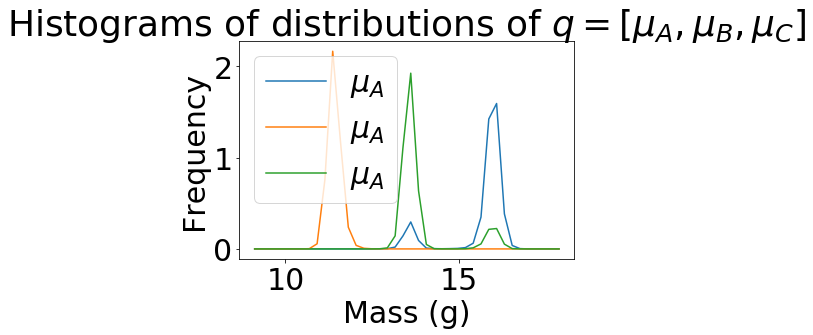

In [208]:
hist1,bins1 = np.histogram(q_traj_sghmc[:,0], bins=40,range=[9,18], density=True)
midx1 = (bins1[0:-1]+bins1[1:])/2
hist2,bins2 = np.histogram(q_traj_sghmc[:,1], bins=40,range=[9,18], density=True)
midx2 = (bins2[0:-1]+bins2[1:])/2
hist3,bins3 = np.histogram(q_traj_sghmc[:,2], bins=40,range=[9,18], density=True)
midx3 = (bins3[0:-1]+bins3[1:])/2
plt.plot(midx1,hist1,label='$\mu_A$')
plt.plot(midx2,hist2,label='$\mu_A$')
plt.plot(midx3,hist3,label='$\mu_A$')

plt.title('Histograms of distributions of $q = [\mu_A, \mu_B, \mu_C]$')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

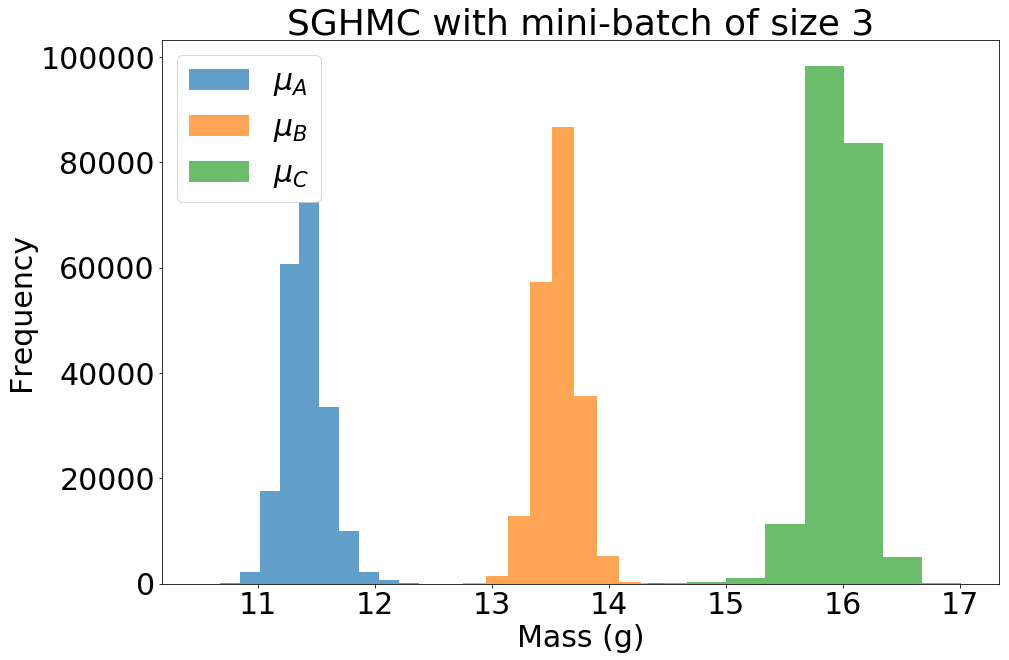

0.18843298434760197
0.17282376682357536
0.21177468348331366
original hmc
0.45285241014597993
0.5051297446596991
0.36794143953521263
11.409573075035071
13.574378640268264
15.971733602068097
original hmc
11.200657651465326
13.585439437292742
15.928504075522618


In [209]:
n = q_traj_sghmc.shape[0]  # get number of time steps
q_traj_sorted_sghmc = q_traj_sghmc.copy()

for k in range(n):
    q_traj_sorted_sghmc[k] = np.sort(q_traj_sghmc[k])

plt.figure(figsize=[15,10])
plt.hist(q_traj_sorted_sghmc[:,0], bins=15,label='$\mu_A$', alpha=0.7)
plt.hist(q_traj_sorted_sghmc[:,1], bins=15, label='$\mu_B$',alpha=0.7)
plt.hist(q_traj_sorted_sghmc[:,2], bins=15, label='$\mu_C$',alpha=0.7)
plt.title('SGHMC with mini-batch of size 3')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(np.std(q_traj_sorted_sghmc[:,0]))
print(np.std(q_traj_sorted_sghmc[:,1]))
print(np.std(q_traj_sorted_sghmc[:,2]))
print('original hmc')
print(np.std(q_traj_sorted[:,0]))
print(np.std(q_traj_sorted[:,1]))
print(np.std(q_traj_sorted[:,2]))

print(np.mean(q_traj_sorted_sghmc[:,0]))
print(np.mean(q_traj_sorted_sghmc[:,1]))
print(np.mean(q_traj_sorted_sghmc[:,2]))
print('original hmc')
print(np.mean(q_traj_sorted[:,0]))
print(np.mean(q_traj_sorted[:,1]))
print(np.mean(q_traj_sorted[:,2]))

SGLD
--

In [81]:
def get_minibatch(y,n):
    # x must be an array
    np.random.shuffle(y)
    batch = y[0:n-1]
    y = y
    return batch, y

def U(q,y):
    m1,m2,m3 = q 
    
    # Your code here 
    prior = np.exp(-((13.5-m1)**2)/32)*np.exp(-((13.5-m2)**2)/32)*np.exp(-((13.5-m3)**2)/32)
    likelihood = sum(np.log(np.exp(-((y-m1)**2)/2)+np.exp(-((y-m2)**2)/2)+np.exp(-((y-m3)**2)/2)))
                        
    V = -np.log(prior)-likelihood
    return V
    


def stochastic_force(q,y,batch_scaling):
    m1,m2,m3 = q
    # constant number in the likelihood part of all derivatives
    denom = np.exp(-((y-m1)**2)/2)+np.exp(-((y-m2)**2)/2)+np.exp(-((y-m3)**2)/2)
    
    dU_dm1 = (13.5-m1)/16 + batch_scaling*sum((y-m1)*np.exp(-((y-m1)**2)/2)/denom)
    dU_dm2 = (13.5-m2)/16 + batch_scaling*sum((y-m2)*np.exp(-((y-m2)**2)/2)/denom)
    dU_dm3 = (13.5-m3)/16 + batch_scaling*sum((y-m3)*np.exp(-((y-m3)**2)/2)/denom)
    
    dU_dq = np.array([dU_dm1,dU_dm2,dU_dm3])
    return dU_dq

def SGLD(q,h,force,y,N):
    R = np.random.normal(0,np.sqrt(h),len(q))
    q = q + (h/2) * stochastic_force(q,y,N) + R
    return q

In [82]:
def run_simulation_SGLD( q0, Nsteps, h, step_function, force_function, y, batch_size):
    
    q_traj = [np.copy(q0)] 
    t_traj = [0]

    q = np.copy(q0) 
    t = 0 
    N = len(y)
    batch_scaling = N/batch_size
    
    for n in range(Nsteps):
        y_batch, y = get_minibatch(y,batch_size)
        q = step_function(q, h, force_function,y_batch,batch_scaling)
        t = t + h 

        q_traj += [q] 
        t_traj += [t] 

    q_traj = np.array(q_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, t_traj

In [104]:
q0 = np.array([12,12,12])

Nsteps = 100000
h = 0.15

# Run one long trajectory of Nsteps, using the OBABO scheme
q_traj_sgld_test, t_traj = run_simulation_SGLD(q0, Nsteps , h, SGLD, stochastic_force, Y, 3)

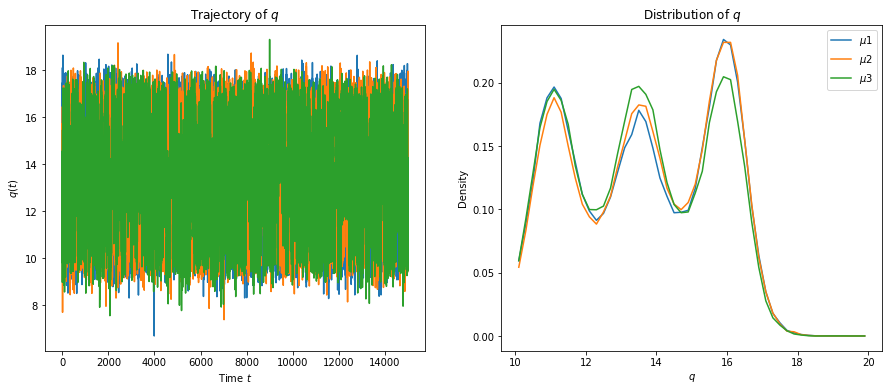

In [106]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
plt.plot( t_traj, q_traj_sgld_test )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

histogram_m1,bins_m1 = np.histogram(q_traj_sgld_test[:,0],bins=50,range=[10,20], density=True)
midx_m1 = (bins_m1[0:-1]+bins_m1[1:])/2
plt.subplot(1,2,2)

plt.plot(midx_m1,histogram_m1,label='$\mu 1$')

histogram_m2,bins_m2 = np.histogram(q_traj_sgld_test[:,1],bins=50,range=[10,20], density=True)
midx_m2 = (bins_m2[0:-1]+bins_m2[1:])/2
plt.plot(midx_m2,histogram_m2,label='$\mu 2$')

histogram_m3,bins_m3 = np.histogram(q_traj_sgld_test[:,2],bins=50,range=[10,20], density=True)
midx_m3 = (bins_m3[0:-1]+bins_m3[1:])/2
plt.plot(midx_m3,histogram_m3,label='$\mu 3$')

plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()
plt.show()

Mean 1: 11.247805476110193 Standard Deviation: 0.8511111299310514
Mean 2: 13.643758065880524 Standard Deviation: 0.9305237808155352
Mean 3: 15.873616619614882 Standard Deviation: 0.7105944636788709


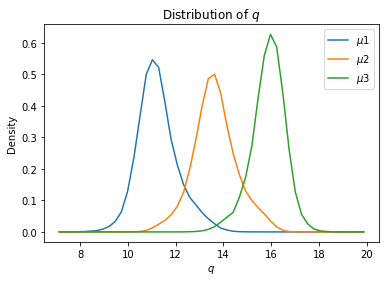

In [107]:
q_traj_sorted_sgld=np.sort(q_traj_sgld_test)

histogram_m1,bins_m1 = np.histogram(q_traj_sorted_sgld[:,0],bins=50,range=[7,20], density=True)
midx_m1 = (bins_m1[0:-1]+bins_m1[1:])/2
plt.plot(midx_m1,histogram_m1,label='$\mu 1$')

histogram_m2,bins_m2 = np.histogram(q_traj_sorted_sgld[:,1],bins=50,range=[7,20], density=True)
midx_m2 = (bins_m2[0:-1]+bins_m2[1:])/2
plt.plot(midx_m2,histogram_m2,label='$\mu 2$')

histogram_m3,bins_m3 = np.histogram(q_traj_sorted_sgld[:,2],bins=50,range=[7,20], density=True)
midx_m3 = (bins_m3[0:-1]+bins_m3[1:])/2
plt.plot(midx_m3,histogram_m3,label='$\mu 3$')

plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()

print('Mean 1:',np.mean(q_traj_sorted_sgld[:,0]), 'Standard Deviation:', np.std(q_traj_sorted_sgld[:,0]))
print('Mean 2:',np.mean(q_traj_sorted_sgld[:,1]),'Standard Deviation:', np.std(q_traj_sorted_sgld[:,1]))
print('Mean 3:',np.mean(q_traj_sorted_sgld[:,2]),'Standard Deviation:', np.std(q_traj_sorted_sgld[:,2]))

In [114]:
H = np.arange(.001,.25,.05)
H

array([0.001, 0.051, 0.101, 0.151, 0.201])

# Error plot for different stepsizes

Error plot 1: Stepsizes compared to variance error 



In [117]:
# Create vector of SGHMC errors

H = [.005,.01,.03,.05,.1,.15,.2]  # stepsizes
true_std = np.array([.5,.6,.4])

Nsteps = 100000

bias_stepsize_sghmc = np.zeros(len(H))
bias_stepsize_sgld = np.zeros(len(H))

for i in range(len(H)):
    print(i)
    q_traj_sghmc, p_traj, t_traj = run_simulation_sghmc(q0, p0, Nsteps , H[i], SGHMC, Y, 3)
    q_traj_sorted_sghmc = np.sort(q_traj_sghmc)
    calc_std_sghmc = np.array([np.std(q_traj_sorted_sghmc[:,0]),
                         np.std(q_traj_sorted_sghmc[:,1]),np.std(q_traj_sorted_sghmc[:,2])])
    bias_stepsize_sghmc[i] = np.mean(abs(true_std - calc_std_sghmc))
    
    q_traj_sgld, t_traj = run_simulation_SGLD(q0, Nsteps , H[i], SGLD, stochastic_force, Y, 3)
    q_traj_sorted_sgld = np.sort(q_traj_sgld)
    calc_std_sgld = np.array([np.std(q_traj_sorted_sgld[:,0]),
                         np.std(q_traj_sorted_sgld[:,1]),np.std(q_traj_sorted_sgld[:,2])])
    bias_stepsize_sgld[i] = np.mean(abs(true_std - calc_std_sgld))
    

    

0
1
2
3
4
5
6


[0.04753857 0.04593617 0.0823632  0.1211377  0.21173442 0.33592715
 0.53857192]


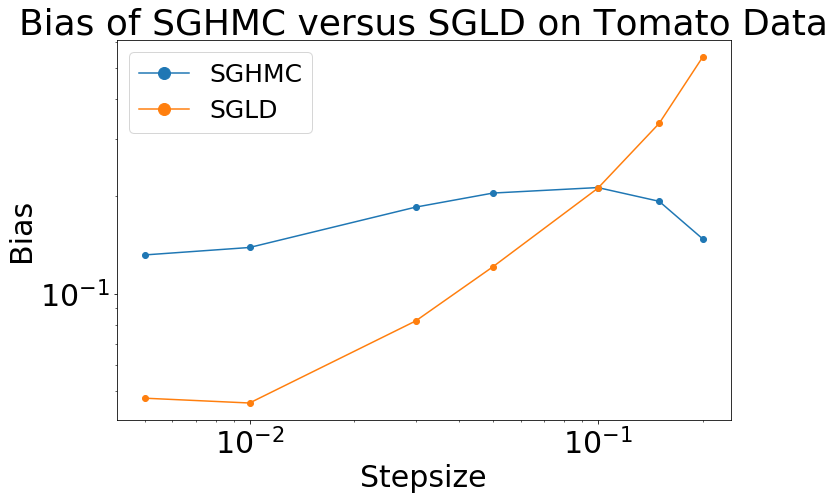

In [131]:
# Plot stepsize bias

plt.figure(figsize = (11,7))
plt.rcParams.update({'font.size': 30})


plt.loglog(H, bias_stepsize_sghmc,'o-', label='SGHMC')
plt.loglog(H, bias_stepsize_sgld,'o-',label='SGLD')

plt.xlabel('Stepsize')
plt.ylabel('Bias')
plt.title('Bias of SGHMC versus SGLD on Tomato Data')
plt.legend(markerscale=2, prop={'size': 25})
plt.show()



In [133]:


batchsizes = [3,5,10,15,30]
true_std = np.array([.5,.6,.4])

Nsteps = 100000
h = .1

bias_batchsize_sghmc = np.zeros(len(batchsizes))
bias_batchsize_sgld = np.zeros(len(batchsizes))

for i in range(len(batchsizes)):
    print(i)
    q_traj_sghmc, p_traj, t_traj = run_simulation_sghmc(q0, p0, Nsteps , h, SGHMC, Y, batchsizes[i])
    q_traj_sorted_sghmc = np.sort(q_traj_sghmc)
    calc_std_sghmc = np.array([np.std(q_traj_sorted_sghmc[:,0]),
                         np.std(q_traj_sorted_sghmc[:,1]),np.std(q_traj_sorted_sghmc[:,2])])
    bias_batchsize_sghmc[i] = np.mean(abs(true_std - calc_std_sghmc))
    
    q_traj_sgld, t_traj = run_simulation_SGLD(q0, Nsteps , h, SGLD, stochastic_force, Y, batchsizes[i])
    q_traj_sorted_sgld = np.sort(q_traj_sgld)
    calc_std_sgld = np.array([np.std(q_traj_sorted_sgld[:,0]),
                         np.std(q_traj_sorted_sgld[:,1]),np.std(q_traj_sorted_sgld[:,2])])
    bias_batchsize_sgld[i] = np.mean(abs(true_std - calc_std_sgld))

0
1
2
3


In [136]:
print(bias_batchsize_sghmc)

[0.20976185 0.20567486 0.20416993 0.202171   0.        ]


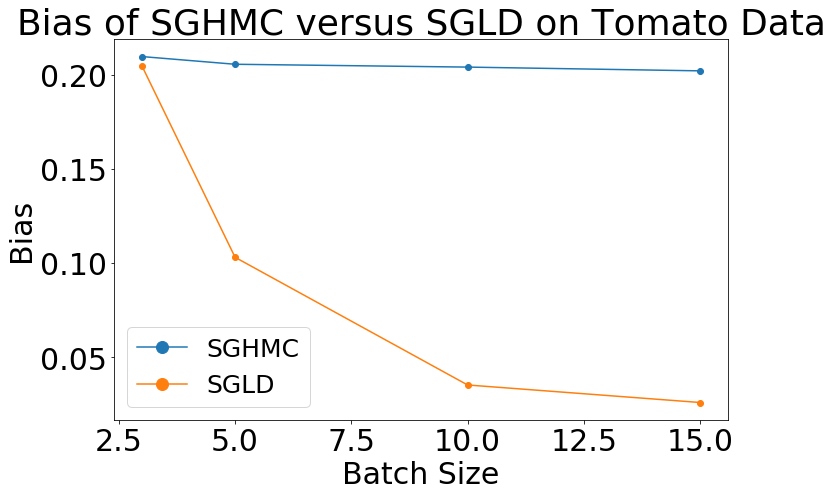

In [177]:
# Plot batchsize bias

plt.figure(figsize = (11,7))
plt.rcParams.update({'font.size': 30})


plt.plot(batchsizes[0:4], bias_batchsize_sghmc[0:4],'o-', label='SGHMC')
plt.plot(batchsizes[0:4], bias_batchsize_sgld[0:4],'o-',label='SGLD')

plt.xlabel('Batch Size')
plt.ylabel('Bias')
plt.title('Bias of SGHMC versus SGLD on Tomato Data')
plt.legend(markerscale=2, prop={'size': 25})
plt.show()



In [192]:
# PLOT with BIG DATA

# Create vector of SGHMC errors

H = [.0001,.0005,.001,.005,.01,.03,.05,.1]  # stepsizes
true_std = np.array([.5,.6,.4])

Nsteps = 100000

bias_stepsize_sghmc2 = np.zeros(len(H))
bias_stepsize_sgld2 = np.zeros(len(H))

for i in range(len(H)):
    print(i)
    q_traj_sghmc, p_traj, t_traj = run_simulation_sghmc(q0, p0, Nsteps , H[i], SGHMC, BigY, 10)
    q_traj_sorted_sghmc = np.sort(q_traj_sghmc)
    calc_std_sghmc = np.array([np.std(q_traj_sorted_sghmc[:,0]),
                         np.std(q_traj_sorted_sghmc[:,1]),np.std(q_traj_sorted_sghmc[:,2])])
    bias_stepsize_sghmc2[i] = np.mean(abs(true_std - calc_std_sghmc))
    
    q_traj_sgld, t_traj = run_simulation_SGLD(q0, Nsteps , H[i], SGLD, stochastic_force, BigY, 10)
    q_traj_sorted_sgld = np.sort(q_traj_sgld)
    calc_std_sgld = np.array([np.std(q_traj_sorted_sgld[:,0]),
                         np.std(q_traj_sorted_sgld[:,1]),np.std(q_traj_sorted_sgld[:,2])])
    bias_stepsize_sgld2[i] = np.mean(abs(true_std - calc_std_sgld))
    

0
1
2
3
4


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


5
6
7


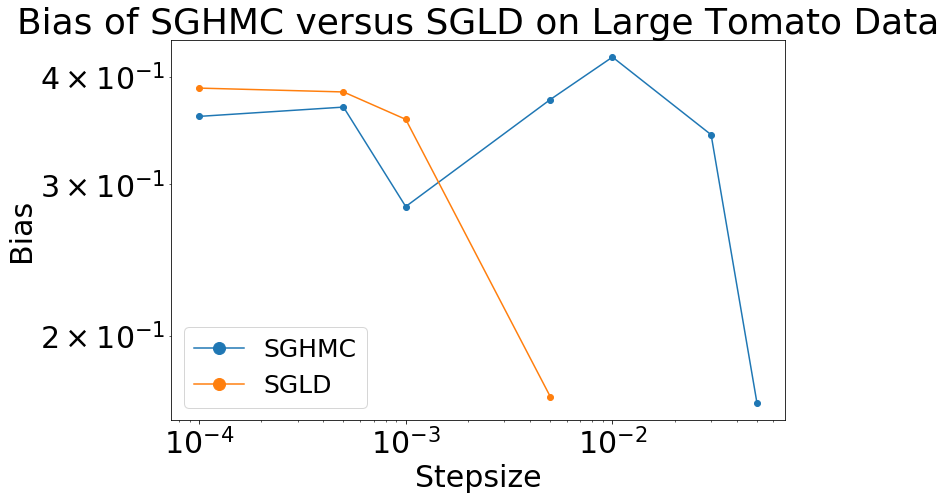

In [193]:
# Plot stepsize bias

plt.figure(figsize = (11,7))
plt.rcParams.update({'font.size': 30})


plt.loglog(H, bias_stepsize_sghmc2,'o-', label='SGHMC')
plt.loglog(H, bias_stepsize_sgld2,'o-',label='SGLD')

plt.xlabel('Stepsize')
plt.ylabel('Bias')
plt.title('Bias of SGHMC versus SGLD on Large Tomato Data')
plt.legend(markerscale=2, prop={'size': 25})
plt.show()



In [213]:


batchsizes2 = [2,4,5,8,10]
true_std = np.array([.5,.6,.4])
true_mean = np.array([11,13,16])

Nsteps = 100000
h = .005

bias_batchsize_sghmc2 = np.zeros(len(batchsizes2))
bias_batchsize_sgld2 = np.zeros(len(batchsizes2))

for i in range(len(batchsizes2)):
    print(i)
    q_traj_sghmc, p_traj, t_traj = run_simulation_sghmc(q0, p0, Nsteps , h, SGHMC, BigY, batchsizes2[i])
    q_traj_sorted_sghmc = np.sort(q_traj_sghmc)
    calc_mean_sghmc = np.array([np.mean(q_traj_sorted_sghmc[:,0]),
                         np.mean(q_traj_sorted_sghmc[:,1]),np.mean(q_traj_sorted_sghmc[:,2])])
    bias_batchsize_sghmc2[i] = np.mean(abs(true_mean - calc_mean_sghmc))
    
    q_traj_sgld, t_traj = run_simulation_SGLD(q0, Nsteps , h, SGLD, stochastic_force, BigY, batchsizes2[i])
    q_traj_sorted_sgld = np.sort(q_traj_sgld)
    calc_mean_sgld = np.array([np.mean(q_traj_sorted_sgld[:,0]),
                         np.mean(q_traj_sorted_sgld[:,1]),np.mean(q_traj_sorted_sgld[:,2])])
    bias_batchsize_sgld2[i] = np.mean(abs(true_mean - calc_mean_sgld))

0
1
2
3
4


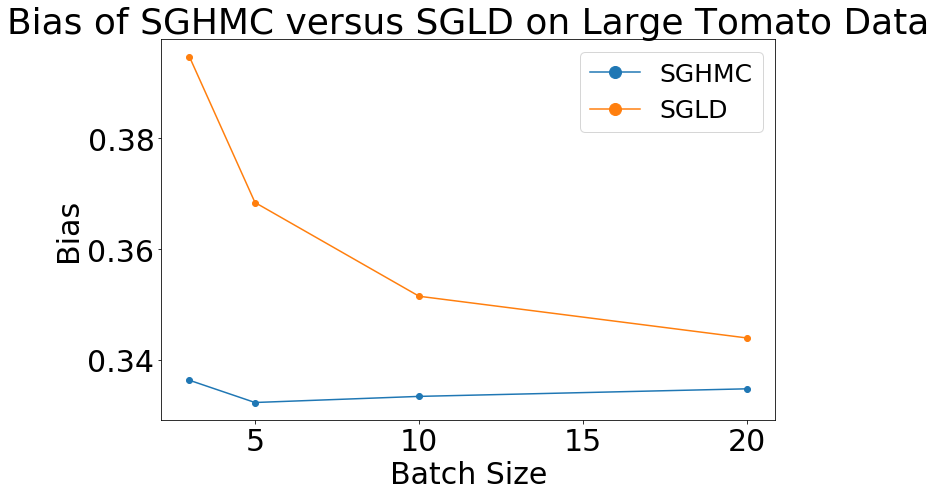

In [215]:
# Plot batchsize bias

plt.figure(figsize = (11,7))
plt.rcParams.update({'font.size': 30})


plt.plot(batchsizes[0:4], bias_batchsize_sghmc2[0:4],'o-', label='SGHMC')
plt.plot(batchsizes[0:4], bias_batchsize_sgld2[0:4],'o-',label='SGLD')

plt.xlabel('Batch Size')
plt.ylabel('Bias')
plt.title('Bias of SGHMC versus SGLD on Large Tomato Data')
plt.legend(markerscale=2, prop={'size': 25})
plt.show()

